# Generative Adversarial Networks (GANs)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, ToTensor, Normalize
from torchvision.datasets import MNIST

In [2]:
def set_seed(seed):
    """Set ALL the random seeds to a fixed value and take out any randomness from cuda kernels."""

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  # uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms.
                                            # Useful when inputs do not change size.
    torch.backends.cudnn.enabled   = False

    return True

In [3]:
# Set up device
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")
    device = 'cpu'

No GPU available!


## Generator and discriminator

Generative Adversarial Networks (GANs) ประกอบด้วย 2 network ที่แข่งกัน คือ 
- <b>Generator</b> ($G$) ทำหน้าที่สร้าง fake image จาก latent variable ($\hat{x}=G(z)$) ดังนั้น layer สุดท้ายจำมีจำนวน neuron เท่ากับจำนวน pixel ของภาพ
- <b>Discriminator</b> ($D$) รับทั้งภาพ real image ($x$) และ fake image ($\hat{x}$) และระบุว่าแต่ละภาพเป็น real (1) หรือ fake (0) image ดังนั้น $D$ จึงเป็น binary classifier (layer สุดท้ายจะมี neuron เดียว)

<img src="../images/gan.png" width="250" /><br />

## Training GANs

สิ่งที่เราต้องทำ คือ ทำให้ $G$ สร้างภาพที่ดีพอที่จะหลอก $G$ ว่าภาพนั้นเป็น real image
- หาก $D$ ระบุแต่ละภาพว่าเป็น real หรือ fake image ได้ถูกต้อง แสดงว่า $G$ ยังไม่ดีพอ ต้อง update $G$
- หาก $D$ หลอก $G$ ได้ ($G$ ระบุภาพ fake image ว่าเป็น real image) ต้อง update $D$ เพื่อให้ระบุได้ถูกต้องมากขึ้น
- เป็น zero-sum game (ถ้า $D$ ดีขึ้น/แย่ลง $G$ จะแย่ลง/ดีขึ้น)

เราจะเทรน model จนกว่า loss ของทั้ง $G$ และ $D$ คงที่

<img src="../images/D_G_losses.png" width="500" /><br />

ถ้าเราเทรนจนได้ loss ของ $G$ หรือ $D$ เป็น 0 ภายในไม่กี่ epoch แสดงว่า training ไม่ดี ต้องทำใหม่

## Pros and cons

- GANs produce sharper and more perceptually realistic results.
- VAEs are stable in training and converge faster. GANs are hard to train and have unclear stopping criteria.
- VAEs provide a generative model and an inference model in a single network, but GANs only provide a generative model.
- VAEs are better justified theoretically, but GANs implicitly maximise likelihood through the combination of two networks.

In [4]:
# Create generator and discirminator classes to be used in a GAN 
class Generator(nn.Module):
    def __init__(self, g_input_dim=100, g_output_dim=28*28):
        super().__init__()
        self.fc1 = nn.Linear(g_input_dim, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, g_output_dim)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        return torch.tanh(self.fc4(x))

class Discriminator(nn.Module):
    def __init__(self, d_input_dim=28*28):
        super().__init__()
        self.fc1 = nn.Linear(d_input_dim, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        return torch.sigmoid(self.fc4(x))

In [5]:
# Initialise a generator (G) and a discriminator (D)
G = Generator().to(device)
D = Discriminator().to(device)

In [6]:
G

Generator(
  (fc1): Linear(in_features=100, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=784, bias=True)
)

In [7]:
D

Discriminator(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=1, bias=True)
)

In [8]:
# Hyperparameters
criterion = nn.BCELoss()
z_dim = 100
bs = 100  # Batch size
lr = 0.0001  # Learning rate
G_optimizer = torch.optim.Adam(G.parameters(), lr=lr)
D_optimizer = torch.optim.Adam(D.parameters(), lr=lr)
n_epochs = 200

In [9]:
# Download and transform the MNIST training dataset
transform = Compose([
    ToTensor(),
    Normalize(mean=(0.5), std=(0.5))  # We don't use mean=(0.1307) and std=(0.3081)
                                      # Otherwise, our GAN wouldn't be trained properly
])
dataset = MNIST(root='../data', train=False, download=True, transform=transform)
# We are not interested in checking the generalisation of the model
# And the test set is smaller than the training set

# Data Loader
loader = DataLoader(dataset=dataset, batch_size=bs, shuffle=True)

In [10]:
# Define training loops for D and G
def D_train(x):
    D.train()
    D_optimizer.zero_grad()

    # Train the discriminator on real images
    x_real = x.view(-1, 28*28).to(device)
    y_real = torch.ones(bs, 1).to(device)  # "ones" means real
    D_output = D(x_real)
    D_real_loss = criterion(D_output, y_real)

    # Train the discriminator on fake images
    z = torch.randn(bs, z_dim).to(device)  # Sample latent vectors (z) randomly
    x_fake = G(z)  # Produce fake images from the sampled z
    y_fake = torch.zeros(bs, 1).to(device)  # "zeros" means fake
    D_output = D(x_fake)
    D_fake_loss = criterion(D_output, y_fake)

    # Combine the losses
    D_loss = D_real_loss + D_fake_loss

    # Model update
    D_loss.backward()
    D_optimizer.step()

    return D_loss.data.item()

def G_train(x):
    G.train()
    G_optimizer.zero_grad()

    # Sample latent vectors (z) randomly and produce fake images from the sampled z
    z = torch.randn(bs, z_dim).to(device)
    G_output = G(z)

    # Obtain scores from the discriminator given the fake images
    D_output = D(G_output)

    # Train the generator to fool the discriminator
    y = torch.ones(bs, 1).to(device)  # "ones" means real
    G_loss = criterion(D_output, y)  # The loss should be low if fake images are classified as real (1)

    # Model update
    G_loss.backward()
    G_optimizer.step()

    return G_loss.data.item()

In [32]:
# Train and validate the network and plot its learning curves
# You can use the "livelossplot" module to plot a real-time evolution of loss and accuracy
n_epochs = 200
D_losses, G_losses = [], []
for epoch in range(1, n_epochs+1):
    for batch_idx, (x, _) in enumerate(loader):
        D_loss = D_train(x)
        G_loss = G_train(x)

    # Store losses after completing each epoch
    D_losses.append(D_loss)
    G_losses.append(G_loss)

    # Save the generator every 20th epochs
    if(np.mod(epoch, 20) == 0):
        torch.save(G.state_dict(), "../data/Generator_{:03d}.pth".format(epoch))

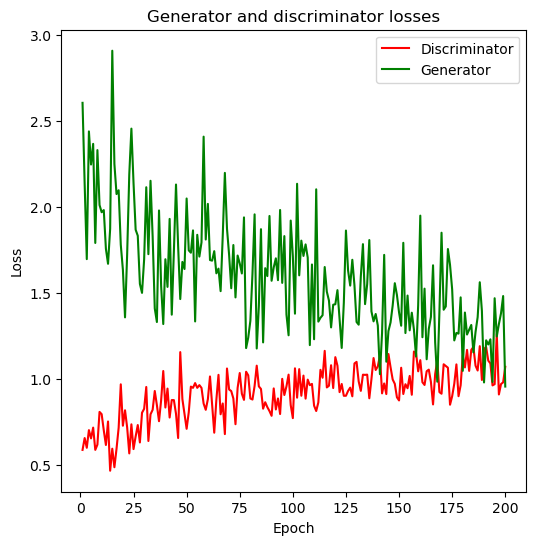

In [33]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(range(1, n_epochs+1), D_losses, c='r', label="Discriminator")
ax.plot(range(1, n_epochs+1), G_losses, c='g', label="Generator")
ax.set(title="Generator and discriminator losses", xlabel="Epoch", ylabel="Loss")
ax.legend();